# Import

In [71]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torchvision import transforms
import numpy as np

from utils import linear_schedule,sigmoid_beta_schedule, add_noise, denoise_step, sample_plot_image, show_tensor_image
from diffusion_model import Unet

# Generate synthetic Image

In [72]:
IMG_SIZE = 64
BATCH_SIZE = 10
img_size = IMG_SIZE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
T = 1000  # Total number of timesteps
# Precompute terms for the diffusion process
betas = sigmoid_beta_schedule(T).to(device)  # [T]
alphas = 1.0 - betas  # [T]
alphas_cumprod = torch.cumprod(alphas, dim=0)  # [T]

In [73]:
model_car = Unet()
model_car.load_state_dict(torch.load('./model_cifar10_car_v4.pth'))

device = torch.device("cuda")
model_car.to(device)

Unet(
  (conv0): Block(
    (double_conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): GELU(approximate='none')
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): GELU(approximate='none')
      (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (down1): Down(
    (down_conv_block): Sequential(
      (0): Block(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): GELU(approximate='none')
          (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (4): GELU(approximate='none')
          (5): BatchNorm2d(128, ep

In [74]:
def generate_image(model, T):
  device = torch.device("cuda")
  model.to(device)

  img = torch.randn((1, 3, 64, 64), device=device)  # [1, 3, img_size, img_size]
  # num_images = 10
  # stepsize = T // num_images
  with torch.no_grad():
    for i in reversed(range(T)):
          #print(i)
          t = torch.full((1,), i, device=device, dtype=torch.long)  # [1]
          img = denoise_step(img, t, model)  # [1, 3, img_size, img_size]
          img = torch.clamp(img, -1.0, 1.0)  # Clamp to maintain [-1, 1] range
  return img

In [75]:
import os
directory = 'synthetic_dataset_car'
if not os.path.exists(directory):
    os.makedirs(directory)

In [76]:
def generate_synthetic_dataset(model, num_images,directory):
  reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        transforms.Lambda(lambda t: t * 255.),
        transforms.Lambda(lambda t: t.numpy().astype(np.uint8)),
        transforms.ToPILImage(),
    ])

  if not os.path.exists(directory):
      os.makedirs(directory)

  device = torch.device("cuda")
  model.to(device)

  for i in range(num_images):
    img = generate_image(model_car, 1000)
    img = img.squeeze(0)
    img = img.detach().cpu()
    img = reverse_transforms(img)
    img.save(f'./{directory}/{i}.png')
    #plt.imshow(img)

In [77]:
generate_synthetic_dataset(model_car,1000,'synthetic_dataset_car')

In [78]:
#!zip -r synthetic_dataset_car.zip synthetic_dataset_car/

updating: synthetic_dataset_car/ (stored 0%)
updating: synthetic_dataset_car/6.png (stored 0%)
updating: synthetic_dataset_car/5.png (stored 0%)
updating: synthetic_dataset_car/9.png (stored 0%)
updating: synthetic_dataset_car/7.png (stored 0%)
updating: synthetic_dataset_car/2.png (stored 0%)
updating: synthetic_dataset_car/0.png (stored 0%)
updating: synthetic_dataset_car/8.png (stored 0%)
updating: synthetic_dataset_car/3.png (stored 0%)
updating: synthetic_dataset_car/1.png (stored 0%)
updating: synthetic_dataset_car/4.png (stored 0%)
updating: synthetic_dataset_car/.ipynb_checkpoints/ (stored 0%)
  adding: synthetic_dataset_car/286.png (stored 0%)
  adding: synthetic_dataset_car/193.png (stored 0%)
  adding: synthetic_dataset_car/612.png (stored 0%)
  adding: synthetic_dataset_car/213.png (stored 0%)
  adding: synthetic_dataset_car/58.png (stored 0%)
  adding: synthetic_dataset_car/188.png (stored 0%)
  adding: synthetic_dataset_car/282.png (stored 0%)
  adding: synthetic_dataset_

In [80]:
#!unzip synthetic_dataset_car.zip

# Preprocess data and Add Synthetic Image to Dataset

In [81]:
import torch
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import glob
from PIL import Image

In [116]:
import os
import glob
from PIL import Image
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import numpy as np

class CombinedCIFAR10CustomDataset(Dataset):
    def __init__(self, cifar_root, custom_folder_path, transform=None):
        """
        Initializes the dataset.
        :param cifar_root: Root directory of the CIFAR-10 dataset.
        :param custom_folder_path: Path to the folder containing additional images.
        :param transform: Transformations to apply to the images.
        """
        # Load CIFAR-10 dataset
        self.cifar_dataset = datasets.CIFAR10(root=cifar_root, train=True, download=True, transform=transform)

        # Filter CIFAR-10 to only include classes 1 and 9, and relabel them to 1 and 0 respectively
        targets = np.array(self.cifar_dataset.targets)
        mask = (targets == 1) | (targets == 9)
        self.cifar_data = np.array(self.cifar_dataset.data)[mask]
        self.cifar_labels = (targets[mask] == 1).astype(int)  # Class 1 becomes 1, Class 9 becomes 0

        # Load custom data
        self.custom_images = []
        for image_path in glob.glob(os.path.join(custom_folder_path, '*.png')):
            image = Image.open(image_path).convert('RGB')
            if transform:
                image = transform(image)
            self.custom_images.append(image)


        self.custom_labels = [1] * len(self.custom_images)

        self.transform = transform

    def __len__(self):
        return len(self.cifar_data) + len(self.custom_images)

    def __getitem__(self, index):
        if index < len(self.cifar_data):
            data = self.cifar_data[index]
            if self.transform:
                data = Image.fromarray(data)
                data = self.transform(data)
            label = self.cifar_labels[index]
        else:
            data = self.custom_images[index - len(self.cifar_data)]
            label = self.custom_labels[index - len(self.cifar_data)]
        return data, label

# Transformation
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Initialize dataset
cifar_root = './data'
custom_folder_path = './synthetic_dataset_car'
combined_dataset = CombinedCIFAR10CustomDataset(cifar_root=cifar_root, custom_folder_path=custom_folder_path, transform=transform)
synthetic_data_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)



Files already downloaded and verified


In [92]:
len(combined_dataset)

11000

In [110]:
import torchvision.datasets as DS

transform = transforms.Compose([transforms.Resize((64, 64)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


def class_extract(cls_list, dataset):
    indx_set = []
    label_set = {}

    new_labels = {cls: i for i, cls in enumerate(cls_list)}

    # go through dataset and find points whose labels are in cls_list
    for indx, data in enumerate(dataset):
        if data[1] in cls_list:
            indx_set.append(indx)
            label_set[indx] = new_labels[data[1]]

    # cat to class 0 and dog to class 1
    for indx in indx_set:
        dataset.targets[indx] = label_set[indx]

    subset = Subset(dataset, indx_set)
    return subset

train_set = DS.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = DS.CIFAR10(root='./data', train=False, download=True, transform=transform)

cls_list = [9,1]
train_subset = class_extract(cls_list, train_set)
test_subset = class_extract(cls_list, test_set)

batch_size = 64
train_loader = DataLoader(train_subset,batch_size=batch_size, shuffle = True)
test_loader = DataLoader(test_subset, batch_size = batch_size)


Files already downloaded and verified
Files already downloaded and verified


In [111]:
print(len(train_subset))
print(len(test_subset))

10000
2000


In [85]:
def check_labels(dataloader):
    labels_list = []
    for _, labels in dataloader:
        labels_list.extend(labels.numpy())
    return labels_list

train_labels = check_labels(train_loader)
test_labels = check_labels(test_loader)
synthetic_labels = check_labels(synthetic_data_loader)


print("Unique labels in train subset:", np.unique(train_labels))
print("Unique labels in test subset:", np.unique(test_labels))
print("Unique labels in synthetic_data_loader subset:", np.unique(synthetic_labels))



Unique labels in train subset: [0 1]
Unique labels in test subset: [0 1]
Unique labels in synthetic_data_loader subset: [0 1]


# Model

In [112]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding =1)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv2d(32,32,kernel_size=3,padding =1)
        self.relu2 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2,stride=2)

        self.conv4 = nn.Conv2d(32,64,kernel_size=3,padding =1)
        self.relu4 = nn.ReLU()
        self.conv5 = nn.Conv2d(64,64,kernel_size=3,padding =1)
        self.relu5 = nn.ReLU()
        self.pool6 = nn.MaxPool2d(2,stride=2)



        self.fc7 = nn.Linear(256*64,128)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(128,1)
        self.sigmoid8 = nn.Sigmoid()

    def forward(self, x):
        h = self.conv1(x)
        h = self.relu1(h)

        h = self.pool3(self.relu2(self.conv2(h)))
        h = self.relu4(self.conv4(h))
        h = self.pool6(self.relu5(self.conv5(h)))

        h = h.view(h.size(0),-1)

        h = self.relu7(self.fc7(h))
        h = self.fc8(h)

        y = self.sigmoid8(h)
        return y

# Traning and Evaluation

Epoch 1/10, Train Risk: 0.5635, Test Risk: 0.5398, Test Accuracy: 0.7360
Epoch 2/10, Train Risk: 0.4387, Test Risk: 0.4729, Test Accuracy: 0.7820
Epoch 3/10, Train Risk: 0.3574, Test Risk: 0.3927, Test Accuracy: 0.8290
Epoch 4/10, Train Risk: 0.3079, Test Risk: 0.3584, Test Accuracy: 0.8505
Epoch 5/10, Train Risk: 0.2744, Test Risk: 0.3428, Test Accuracy: 0.8570
Epoch 6/10, Train Risk: 0.2416, Test Risk: 0.3101, Test Accuracy: 0.8760
Epoch 7/10, Train Risk: 0.2109, Test Risk: 0.3213, Test Accuracy: 0.8715
Epoch 8/10, Train Risk: 0.1830, Test Risk: 0.2775, Test Accuracy: 0.8895
Epoch 9/10, Train Risk: 0.1517, Test Risk: 0.2911, Test Accuracy: 0.8860
Epoch 10/10, Train Risk: 0.1276, Test Risk: 0.2989, Test Accuracy: 0.8855


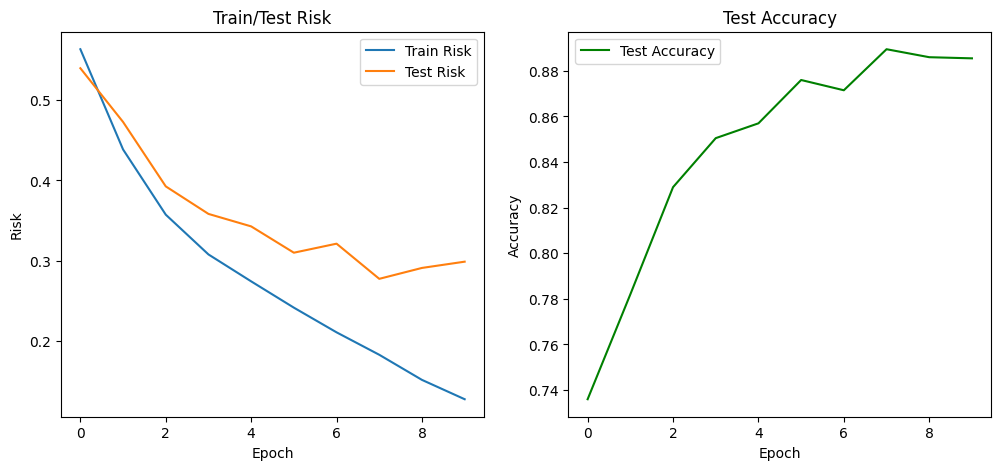

Epoch 1/10, Train Risk: 0.6208, Test Risk: 0.5792, Test Accuracy: 0.7040
Epoch 2/10, Train Risk: 0.5152, Test Risk: 0.4979, Test Accuracy: 0.7565
Epoch 3/10, Train Risk: 0.4142, Test Risk: 0.3950, Test Accuracy: 0.8265
Epoch 4/10, Train Risk: 0.3487, Test Risk: 0.4188, Test Accuracy: 0.8010
Epoch 5/10, Train Risk: 0.3258, Test Risk: 0.3510, Test Accuracy: 0.8485
Epoch 6/10, Train Risk: 0.2858, Test Risk: 0.3186, Test Accuracy: 0.8630
Epoch 7/10, Train Risk: 0.2479, Test Risk: 0.3107, Test Accuracy: 0.8660
Epoch 8/10, Train Risk: 0.2189, Test Risk: 0.3008, Test Accuracy: 0.8740
Epoch 9/10, Train Risk: 0.1878, Test Risk: 0.3079, Test Accuracy: 0.8760
Epoch 10/10, Train Risk: 0.1695, Test Risk: 0.3082, Test Accuracy: 0.8795


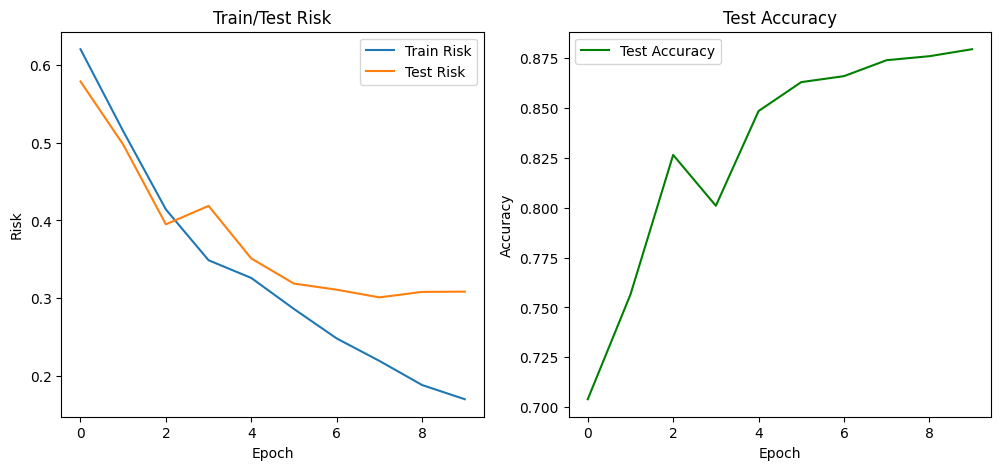

In [127]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import random

class Trainer:
    def __init__(self, model, train_loader, test_loader):
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(model.parameters(), lr=0.0003)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)
        random.seed(1508)
        np.random.seed(1508)
        torch.manual_seed(1508)
        torch.cuda.manual_seed_all(1508)


    def train_epoch(self):
        self.model.train()
        running_loss = 0.0
        for inputs, labels in self.train_loader:
            inputs, labels = inputs.to(self.device), labels.to(self.device).float().view(-1, 1)

            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        return running_loss / len(self.train_loader.dataset)

    def evaluate(self):
        self.model.eval()
        running_loss = 0.0
        predictions = []
        true_labels = []
        with torch.no_grad():
            for inputs, labels in self.test_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device).float().view(-1, 1)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                predicted_labels = outputs.round().cpu().numpy()
                predictions.extend(predicted_labels)
                true_labels.extend(labels.cpu().numpy())
        accuracy = accuracy_score(true_labels, predictions)
        return running_loss / len(self.test_loader.dataset), accuracy

    def train(self, num_epochs):
        train_risks = []
        test_risks = []
        test_accuracies = []

        for epoch in range(num_epochs):
            train_risk = self.train_epoch()
            test_risk, test_accuracy = self.evaluate()

            train_risks.append(train_risk)
            test_risks.append(test_risk)
            test_accuracies.append(test_accuracy)

            print(f'Epoch {epoch+1}/{num_epochs}, Train Risk: {train_risk:.4f}, Test Risk: {test_risk:.4f}, Test Accuracy: {test_accuracy:.4f}')

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        plt.plot(train_risks, label='Train Risk')
        plt.plot(test_risks, label='Test Risk')
        plt.title('Train/Test Risk')
        plt.xlabel('Epoch')
        plt.ylabel('Risk')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(test_accuracies, label='Test Accuracy', color='green')
        plt.title('Test Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.show()

trainer = Trainer(model=CNN(), train_loader=synthetic_data_loader, test_loader=test_loader)
trainer.train(num_epochs=10)

trainer = Trainer(model=CNN(), train_loader=train_loader, test_loader=test_loader)
trainer.train(num_epochs=10)
